# RSA: LeNet-5 x FashionMNIST

*Version History*

* **5.0** - Check functionality of ``RepresentationalSimilarityTrainer`` and RSA functions via test run
* **5.1** - Analyze grid search (weight & transform) minimizing RSA scores for standard LeNet-5 $\times$ FashionMNIST
* **5.2** - Analyze results of experiment testing various methods to compute and compare RDMs
* **5.3** - Include additional runs in initial grid search (weight & transform)
* **5.4** - Update paths to account for revamped project structure, modify notation in math section


## Preparation


### Imports & Constants

In [1]:
import random
from datetime import datetime
from functools import partial
from pathlib import Path
from typing import Any, Callable, Dict, Literal, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.font_manager import FontProperties
from omegaconf import OmegaConf
from pyfonts import load_font
from torch import linalg as LA
from torch import nn
from torch.nn import functional as F
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy

from src.base_classes.base_loader import BaseLoader
from src.datasets.fashionmnist import FashionMNIST
from src.models.lenet import LeNet
from src.training.representational_similarity_trainer import RepresentationalSimilarityTrainer
from src.utils.classification_transforms import ClassificationTransformsTrain, ClassificationTransformsVal
from src.utils.data import *
from src.utils.training import evaluate_classifier
from src.visualization.color import get_color
from src.visualization.saving import save_figure


# Paths
DATA_DIR = "../data"
CHKPT_PATH = "../models/lenet_fashionmnist_basic/checkpoint.pt"

# Seeds
TORCH_SEED = 89
SEEDS = OmegaConf.create({
    "shuffle_seed": 858,
    "split_seed": 42
})

# Dataloader
VAL_SPLIT = 0.2
BATCH_SIZE = 128
NUM_WORKERS = 0

# Training
DEVICE = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

# Custom font & color for plotting purposes
indie_flower = load_font(
   font_url="https://github.com/google/fonts/blob/main/ofl/indieflower/IndieFlower-Regular.ttf?raw=true"
)
anthracite = get_color("anthracite", tint=0.2)
anthracite_light = get_color("anthracite", tint=0.75)

### Helper Functions

* ``get_timestamp`` &rarr; Get a timestamp of the current date and time.
* ``set_seeds`` &rarr; Set random seeds for reproducibility.

In [2]:
def get_timestamp() -> str:
    """Get a timestamp of the current date and time."""
    
    return datetime.now().strftime("%Y-%m_%d-%H-%M-%S")


def set_seeds() -> None:
    """Set random seeds for reproducibility."""
    
    random.seed(TORCH_SEED)
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


### FashionMNIST Dataset

In [3]:
# Prepare transforms
train_transform = ClassificationTransformsTrain(
    mean=[0.2860],
    std=[0.3205],
    crop_size=32,
    crop_scale=OmegaConf.create({"lower": 0.8, "upper": 0.8}),
    crop_ratio=OmegaConf.create({"lower": 1.0, "upper": 1.0}),
    flip_prob=0.5,
    ta_wide=False,
    random_erase_prob=0
)

val_transform = ClassificationTransformsVal(
    mean=[0.2860],
    std=[0.3205],
    resize_size=32,
    crop_size=32
)

# Load FashionMNIST dataset
fashionmnist = FashionMNIST(
    data_dir=DATA_DIR,
    train=True,
    load_into_memory=False
)

# Prepare dataloaders
base_loader = BaseLoader(
    dataset=fashionmnist,
    main_transform=train_transform,
    val_transform=val_transform,
    val_split=VAL_SPLIT,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    seeds=SEEDS
)
TRAIN_LOADER = base_loader.get_dataloader(mode="main")
VAL_LOADER = base_loader.get_dataloader(mode="val")

### LeNet-5

* ``load_pretrained_lenet`` &rarr; Load the pre-trained LeNet-5 network.

In [4]:
def load_pretrained_lenet(
    is_training: bool = False
) -> nn.Module:
    """Load the pre-trained LeNet-5 network.

    Args:
        is_training: If True, the network is set to training mode and
          gradients are enabled.  If False, the network is set to
          evaluation mode and gradients are disabled.

    Returns:
        The pre-trained LeNet-5 network.
    """

    # Initialize network
    lenet = LeNet().to(DEVICE)

    # Load pre-trained weights
    lenet.load_state_dict(
        torch.load(
            CHKPT_PATH,
            map_location=DEVICE,
            weights_only=False
        )["model_state_dict"]
    )

    # Set to evaluation mode and disable gradients, if applicable
    if not is_training:
        lenet.eval()
        lenet.requires_grad_(False)
    
    return lenet


Next, we initialize the LeNet-5 network with pre-trained weights, and check its performance.

In [5]:
# Criterion used to evaluate classification performance of LeNet-5
criterion = nn.CrossEntropyLoss()

# Additional metrics used to evaluate LeNet-5
PREDICTION_METRICS = MetricCollection({
    "Accuracy@1": MulticlassAccuracy(
        num_classes=10,
        top_k=1,
        average="micro",
        multidim_average="global"
    ),
    "Accuracy@5": MulticlassAccuracy(
        num_classes=10,
        top_k=5,
        average="micro",
        multidim_average="global"
    )
})

# Evaluate performance
results = evaluate_classifier(
    model=load_pretrained_lenet(),
    test_loader=VAL_LOADER,  # same validation set used during training
    criterion=criterion,
    metrics=PREDICTION_METRICS,
    device=DEVICE
)

# Load meta-data from checkpoint
epoch_idx = torch.load(
    CHKPT_PATH,
    map_location=DEVICE,
    weights_only=False
)["epoch_idx"]
output_text = [f"Results on validation set after {epoch_idx} epochs:"]

# Print results
for metric, value in results.items():
    output_text.append(f"{metric}: {value:.3f}")
print("\n  ".join(output_text))

Evaluating LeNet: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 16.66batch/s]


Results on validation set after 74 epochs:
  Loss: 0.232
  Accuracy@1: 0.916
  Accuracy@5: 0.999


In [6]:
print(load_pretrained_lenet())

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): Rearrange('b c h w -> b (c h w)', c=120, h=1, w=1)
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


### Training Configuration

Next, we specify those parameters of the training configuration ``cfg`` used by the ``RepresentationalSimilarityTrainer``  
class that shouldn't change across experiments. **Parameters that have to be set individually for each experiment are**:

* hooks.ref
* hooks.train
* optimizer.params
* paths.checkpoints
* paths.tensorboard
* performance.patience
* training.num_epochs

**When training is to be resumed from a saved checkpoint**, the following parameter needs to be set as well:

* training.resume_from

In [7]:
cfg_dict = {
    "checkpoints": {
        "delete_previous": True,
        "save_best_model": True,
        "save_frequency": 5
    },
    "dataloader": {
        "batch_size": BATCH_SIZE
    },
    "model": {
        "name": "LeNet"
    },
    "optimizer": {
        "name": "SGD"
    },
    "performance": {
        "evaluation_metric": "Loss",
        "higher_is_better": False,
        "min_delta": 0.0,
        "evaluate_on": "val",
        "keep_previous_best_score": True,
        
    },
    "tensorboard": {
        "updates_per_epoch": {
            "train": 10,
            "val": 10
        }
    },
    "training": {
        "resume_from": None
    }
}

# Convert to DictConfig and inspect configuration
cfg = OmegaConf.create(cfg_dict)
print(f"\033[1mGeneral configuration\033[0m:\n\n{OmegaConf.to_yaml(cfg)}")

General configuration:

checkpoints:
  delete_previous: true
  save_best_model: true
  save_frequency: 5
dataloader:
  batch_size: 128
model:
  name: LeNet
optimizer:
  name: SGD
performance:
  evaluation_metric: Loss
  higher_is_better: false
  min_delta: 0.0
  evaluate_on: val
  keep_previous_best_score: true
tensorboard:
  updates_per_epoch:
    train: 10
    val: 10
training:
  resume_from: null



## RSA


### Helper Functions

* ``_get_upper_tri_matrix`` &rarr; Extract the upper triangular part of a square matrix.
* ``_validate_activations`` &rarr; Validate activations from which to compute an RDM.
* ``_is_vector`` &rarr; Check if the input is a ``torch.Tensor`` of dimension 1.

In [8]:
def _get_upper_tri_matrix(A: torch.Tensor) -> torch.Tensor:
    """Extract the upper triangular part of a square matrix.

    Args:
        A: The square matrix from which to extract the upper triangular
          matrix (excluding the diagonal).

    Returns:
        The upper triangular matrix (excluding the diagonal) of the
        square matrix ``A``, flattened into a vector using row-major
        order.
    """

    mask = torch.triu(torch.ones_like(A, dtype=torch.bool), diagonal=1)
    return A[mask]


def _validate_activations(activations: torch.Tensor) -> None:
    """Validate activations from which to compute an RDM.

    This function is meant to be called on a matrix of activations from
    which to compute an RDM.  Rows of the matrix are associated with
    different stimuli, while columns correspond to unit activations.
    N stimuli give rise to N * (N - 1) / 2 distinct pairwise distances.
    Hence, there should be activations for at least N >= 3 stimuli.

    Args:
        activations: The matrix of activations from which to compute an
          RDM.  Must be a 2-D tensor of size (N, M), where N >= 3 is the
          number of stimuli (i.e., the batch size), and M >= 2 is the
          number of unit activations per stimulus.

    Raises:
        ValueError: If the ``activations`` tensor does not meet the size
          and dimensionality requirements stated above.
    """
    
    if not isinstance(activations, torch.Tensor):
        raise ValueError(
            f"'activations' should be of type torch.Tensor, but is of type {type(activations)}.'"
        )
    
    if activations.dim() != 2:
        raise ValueError(
            f"'activations' should be 2-dimensional, but has {activations.dim()} dimensions."
        )

    if activations.size(dim=0) < 3:
        raise ValueError(
            "'activations' should contain activations for at least 3 stimuli."
        )

    if activations.size(dim=1) < 2:
        raise ValueError(
            "The number of unit activations per stimulus should be at least 2."
        )


def _is_vector(x: torch.Tensor) -> bool:
    """Check if the input is a ``torch.Tensor`` of dimension 1."""
    
    return isinstance(x, torch.Tensor) and x.dim() == 1


### Compute RDMs

* ``compute_rdm_euclidean`` &rarr; Compute an RDM using Euclidean distance.
* ``compute_rdm_correlation`` &rarr; Compute an RDM using (Pearson) correlation distance.
* ``compute_rdm`` &rarr; Compute an RDM using the specified method.


#### Euclidean Distance

We make use of the following identity in the ``compute_rdm_euclidean`` function: For two vectors $\mathbf{x}$ and $\mathbf{y}$,  
the squared Euclidean distance can be computed as follows:

$$
\lVert \mathbf{x} - \mathbf{y} \rVert_2^2 = \langle \mathbf{x} - \mathbf{y}, \mathbf{x} - \mathbf{y} \rangle = \lVert \mathbf{x} \rVert_2^2 + \lVert \mathbf{y} \rVert_2^2 - 2 \mathbf{x}^{\top} \mathbf{y} \,. \tag{1}
$$

Let $\mathbf{x}^{\top} = \mathbf{A}_{i,:}$ and $\mathbf{y}^{\top} = \mathbf{A}_{j,:}$ correspond to two rows of an $N \times M$ matrix $\mathbf{A}$ of activations. Note that $\mathbf{A}_{i,:}$  
and $\mathbf{A}_{j,:}$ are row vectors by definition. By setting these equal to $\mathbf{x}^{\top}$ and $\mathbf{y}^{\top}$, respectively, we stick to our  
convention of working with column vectors $\mathbf{x}$ and $\mathbf{y}$. Rewriting (1), we get

$$
\lVert (\mathbf{A}_{i,:})^{\top} - (\mathbf{A}_{j,:})^{\top} \rVert_2^2 = \lVert (\mathbf{A}_{i,:})^{\top} \rVert_2^2 + \lVert (\mathbf{A}_{j,:})^{\top} \rVert_2^2 - 2 \mathbf{A}_{i,:} (\mathbf{A}_{j,:})^{\top} = \lVert (\mathbf{A}_{i,:})^{\top} \rVert_2^2 + \lVert (\mathbf{A}_{j,:})^{\top} \rVert_2^2 - 2 (\mathbf{A} \mathbf{A}^{\top})_{i,j} \,. \tag{2}
$$

The last identity follows from the definition of matrix multiplication and the observation that the transpose  
of the $j$-th row of $\mathbf{A}$ is equal to the $j$-th column of $\mathbf{A}^{\top}$, i.e., $(\mathbf{A}_{j,:})^{\top} = (\mathbf{A}^{\top})_{:,j}$. Next comes the slightly  
creative part. We introduce another matrix $\mathbf{B}$ whose entry at position $(i, j)$ is given by

$$
B_{i,j} = \sum_{k=1}^M (A_{i,k})^2 = \lVert (\mathbf{A}_{i,:})^{\top} \rVert_2^2, \quad i, j \in \{1, \dots, N\} \,. \tag{3}
$$

Note that $B_{i,j}$ only depends on $i$. In other words, $\mathbf{B}$ is simply a column vector that's replicated and stacked  
next to each other $N$ times. Consequently, $\mathbf{B}^{\top}$ is a row vector that's stacked underneath each other  
multiple times. In particular, we have

$$
(\mathbf{B}^{\top})_{i,j} = B_{j,i} = \lVert (\mathbf{A}_{j,:})^{\top} \rVert_2^2 \,.
$$

Hence, we can plug the definition of $\mathbf{B}$ given in (3) into equation (2) to arrive at

$$
\lVert (\mathbf{A}_{i,:})^{\top} - (\mathbf{A}_{j,:})^{\top} \rVert_2^2 = B_{i,j} + (\mathbf{B}^{\top})_{i,j} - 2 (\mathbf{A} \mathbf{A}^{\top})_{i,j} = (\mathbf{B} + \mathbf{B}^{\top} - 2 \mathbf{A} \mathbf{A}^{\top})_{i,j} \,. \tag{4}
$$

In [9]:
def compute_rdm_euclidean(
    activations: torch.Tensor,
    center_activations: bool = False,
    normalize_distances: bool = True,
    distance_type: Literal["squared", "non-squared"] = "squared"
) -> torch.Tensor:
    """Compute an RDM using Euclidean distance.

    Note:
        This function returns only the upper triangular matrix of the
        computed RDM in vectorized form (row-major order).

    Args:
        activations: The matrix of activations from which to compute the
          RDM.  Must be a 2-D tensor of size (N, M), where N >= 3 is the
          number of stimuli, and M >= 2 is the number of unit
          activations per stimulus.
        center_activations: Whether to center the activations for each
          stimulus before computing distances.
        normalize_distances: Whether to normalize the squared pairwise
          distances by the number M of unit activations per stimulus.
        distance_type: Whether to return squared or non-squared
          distances.

    Returns:
        The RDM (in vectorized form) computed from the data using
        Euclidean distance.
    """

    _validate_activations(activations)

    if distance_type not in ["squared", "non-squared"]:
        raise ValueError(
            f"'distance_type' should be either 'squared' or 'non-squared', but got {distance_type}."
        )

    if center_activations:
        activations -= activations.mean(dim=1, keepdim=True)
    
    # Compute squared pairwise distances
    norms_squared = torch.sum(torch.square(activations), dim=1, keepdim=True)
    distances_squared = norms_squared + norms_squared.T - 2 * torch.mm(activations, activations.T)

    # Clamp negative values (potential numerical inaccuracies) and extract RDM
    rdm = _get_upper_tri_matrix(torch.clamp(distances_squared, min=0.0))

    if normalize_distances:
        rdm = rdm / activations.size(dim=1)

    if distance_type == "non-squared":
        rdm = torch.sqrt(rdm)
    
    return rdm


#### Correlation Distance

In [10]:
def compute_rdm_correlation(
    activations: torch.Tensor,
    center_activations: bool = False
) -> torch.Tensor:
    """Compute an RDM using (Pearson) correlation distance.

    Note:
        This function returns only the upper triangular matrix of the
        computed RDM in vectorized form (row-major order).

    Args:
        activations: The matrix of activations from which to compute the
          RDM.  Must be a 2-D tensor of size (N, M), where N >= 3 is the
          number of stimuli, and M >= 2 is the number of unit
          activations per stimulus.
        center_activations: Whether to center the activations for each
          stimulus before computing distances.

    Returns:
        The RDM (in vectorized form) computed from the data using
        (Pearson) correlation distance.
    """

    _validate_activations(activations)

    if center_activations:
        activations -= activations.mean(dim=1, keepdim=True)

    rdm = 1 - _get_upper_tri_matrix(torch.corrcoef(activations))

    return rdm


#### Main Function

In [11]:
def compute_rdm(
    activations: torch.Tensor,
    method: str,
    **kwargs: Any
) -> torch.Tensor:
    """Compute an RDM using the specified method.

    Args:
        activations: The matrix of activations from which to compute the
        RDM.  Must be a 2-D tensor of size (N, M), where N >= 3 is the
          number of stimuli, and M >= 2 is the number of unit
          activations per stimulus.
        method: The method to use for computing the RDM.
        **kwargs: Additional keyword arguments to pass to the specific
          function used to compute the RDM.

    Returns:
        The RDM (in vectorized form) computed from the data using the
          specified method.
    """

    methods: Dict[str, Callable[..., torch.Tensor]] = {
        "euclidean": compute_rdm_euclidean,
        "correlation": compute_rdm_correlation,
    }

    if method not in methods:
        raise ValueError(
            f"'method' should be one of {list(methods.keys())}, but got {method}."
        )

    return methods[method](activations, **kwargs)


### Compare RDMs

* ``compare_rdm_cosine`` &rarr; Compare two RDMs using cosine similarity.
* ``compare_rdm`` &rarr; Compare two RDMs using the specified method.


#### Cosine Similarity

In [12]:
def compare_rdm_cosine(
    rdm1: torch.Tensor,
    rdm2: torch.Tensor
) -> torch.Tensor:
    """Compare two RDMs using cosine similarity.

    Args:
        rdm1: The first RDM in vectorized form.
        rdm2: The second RDM in vectorized form.

    Returns:
        The cosine similarity between the two RDMs.
    """

    if not (_is_vector(rdm1) and _is_vector(rdm2)):
        raise ValueError(
            "Both 'rdm1' and 'rdm2' should be tensors of dimension 1."
        )
    
    cosine_similarity = torch.dot(rdm1, rdm2) / (
        LA.vector_norm(rdm1, ord=2) * LA.vector_norm(rdm2, ord=2)
    )
    return cosine_similarity


#### Main Function

In [13]:
def compare_rdm(
    rdm1: torch.Tensor,
    rdm2: torch.Tensor,
    method: str,
    **kwargs: Any
) -> torch.Tensor:
    """Compare two RDMs using the specified method.

    Args:
        rdm1: The first RDM in vectorized form.
        rdm2: The second RDM in vectorized form.
        method: The method to use for comparing the RDMs.
        **kwargs: Additional keyword arguments to pass to the specific
          function used to compare the RDMs.

    Returns:
        The similarity between the two RDMs based on the specified
        method.
    """

    methods: dict[str, Callable[..., torch.Tensor]] = {
        "cosine": compare_rdm_cosine
    }

    if method not in methods:
        raise ValueError(
            f"'method' should be one of {list(methods.keys())}, but got {method}."
        )

    return methods[method](rdm1, rdm2, **kwargs)


### Custom Loss

* ``rsa_loss`` &rarr; A weighted loss combining cross-entropy and repr. similarity.

In [14]:
def rsa_loss(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    activations1: torch.Tensor,
    activations2: torch.Tensor,
    method_compute: Callable[[torch.Tensor], torch.Tensor],
    method_compare: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    weight_rsa_score: float,
    rsa_transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None
) -> Tuple[torch.Tensor, torch.Tensor]:
    """A weighted loss combining cross-entropy and repr. similarity.

    Note:
        Both, the ``method_compute`` and the ``method_compare``
        functions should take as arguments only the activations and
        RDMs, respectively.  Additional arguments must already be
        pre-bound to these functions using the ``partial`` function of
        the ``functools`` module.
    
    Args:
        predictions: The model predictions.
        targets: The target values.
        activations1: First set of activations.  Must be a 2-D tensor of
          size (N, M), where N >= 3 is the number of stimuli and M >= 2
          is the number of unit activations per stimulus.
        activations2: Second set of activations.  Must be a 2-D tensor
          of size (N, K), where N >= 3 is the number of stimuli and
          K >= 2 is the number of unit activations per stimulus.
        method_compute: The method used to compute the RDMs from the
          activations.
        method_compare: The method used to compare RDMs.
        weight_rsa_score: The weight attributed to the (transformed) RSA
          score in the weighted loss combination.
        rsa_transform: The transformation to apply to the raw RSA score.

    Returns:
        A tuple consisting of the raw RSA score between the two networks
        and the weighted loss.

    Raises:
        ValueError: If ``weight_rsa_score`` is outside the range [0, 1]
          or if one of the activation tensors does not meet the size and
          dimensionality requirements.
    """

    if not 0 <= weight_rsa_score <= 1:
        raise ValueError(
            "'weight_rsa_score' should be a float in the range [0, 1], "
            f"but got {weight_rsa_score}."
        )

    # Check activation tensors
    _validate_activations(activations1)
    _validate_activations(activations2)
    if activations1.size(dim=0) != activations2.size(dim=0):
        raise ValueError(
            "'activations1' and 'activations2' should have the same number of rows."
        )

    # Compute cross-entropy loss
    loss = F.cross_entropy(predictions, targets)

    # Compute RSA score
    rsa_score = method_compare(
        method_compute(activations1),
        method_compute(activations2)
    )

    # Transform RSA score & compute weighted loss
    rsa_score_transformed = rsa_score if rsa_transform is None else rsa_transform(rsa_score)
    weighted_loss = weight_rsa_score * rsa_score_transformed + (1 - weight_rsa_score) * loss
    
    return rsa_score, weighted_loss


## Experiments


### Penultimate Layer

## Data Analysis: LeNet-5 x FashionMNIST

### Grid Search: Weight RSA Score & RSA Transform

In [15]:
# Accuracy of standard LeNet-5
lenet_acc = results["Accuracy@1"].item()

# Load and prepare data
weight_transform = parse_log_dir(
    "../out/lenet_fashionmnist/representational_similarity/transform_weight/2024-10-17_13-53-39",
    get_training_results,
    mode="val"
)
additional_runs = parse_log_dir(
    "../out/lenet_fashionmnist/representational_similarity/transform_weight/2024-10-29_21-26-29",
    get_training_results,
    mode="val"
)
weight_transform = pd.concat([weight_transform, additional_runs])
weight_transform = weight_transform.drop(columns="Accuracy@5")
weight_transform = weight_transform.rename(columns={"Accuracy@1": "Acc@1"})
weight_transform = weight_transform.sort_values(by=["rsa_transform", "weight_rsa", "run_id"])
weight_transform

,rsa_transform,weight_rsa,run_id,Loss,RSAScore,Acc@1,Epochs
0,abs,0.0,1,0.205,0.996,0.923,1
1,abs,0.0,2,0.196,0.995,0.927,1
2,abs,0.0,3,0.195,0.996,0.929,2
3,abs,0.0,4,0.192,0.996,0.928,1
4,abs,0.0,5,0.196,0.996,0.928,2
...,...,...,...,...,...,...,...
15,square,1.0,1,0.000,0.000,0.100,8
16,square,1.0,2,0.006,0.048,0.100,58
17,square,1.0,3,0.000,0.000,0.100,4
18,square,1.0,4,0.000,0.000,0.100,3


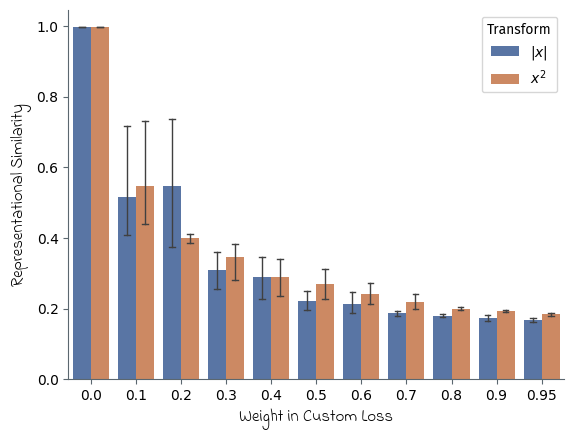

In [16]:
# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    ax = sns.barplot(
        data=weight_transform[weight_transform["weight_rsa"] < 1.0],
        x="weight_rsa",
        y="RSAScore",
        hue="rsa_transform",
        palette="deep",
        errorbar=("ci", 95),
        capsize=.25,
        err_kws={"color": ".25", "linewidth": 1}
    )

# Add axis labels
ax.set_xlabel("Weight in Custom Loss", font=indie_flower, size=12)
ax.set_ylabel("Representational Similarity", font=indie_flower, size=12)

# Customize legend
h, _ = ax.get_legend_handles_labels()
ax.legend(
    h,
    [r"$\vert x \vert$", r"$x^2$"],
    title="Transform",
    title_fontproperties=FontProperties(family="Fira Sans")
)

# Control figure aesthetics
sns.despine(ax=ax)
ax.tick_params(color=anthracite)

fig_grid_search_similarity = ax.get_figure()
plt.show()

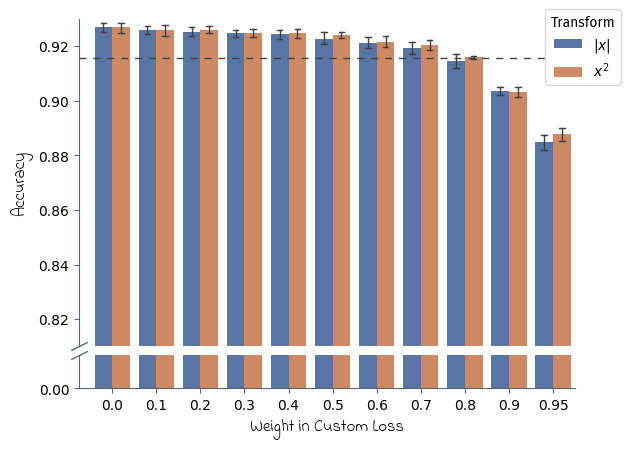

In [17]:
# Prepare plot with "broken" axis
# Adapted from https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
with sns.axes_style({"axes.edgecolor": anthracite}):
    fig_grid_search_accuracy, (ax_top, ax_bottom) = plt.subplots(
        nrows=2,
        ncols=1,
        sharex=True,
        gridspec_kw={
            "height_ratios": [10, 1],
            "hspace": 0.05
        }
    )
kwargs = dict(
    marker=[(-1, -.5), (1, .5)],
    markersize=12,
    linestyle="none",
    mec=anthracite,
    mew=1,
    clip_on=False
)
ax_top.plot(0, transform=ax_top.transAxes, **kwargs)
ax_bottom.plot(1, transform=ax_bottom.transAxes, **kwargs)
ax_bottom.set_ylim(0, 0.012)

# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    sns.barplot(
        data=weight_transform[weight_transform["weight_rsa"] < 1.0],
        x="weight_rsa",
        y="Acc@1",
        hue="rsa_transform",
        palette="deep",
        errorbar=("ci", 95),
        capsize=.25,
        err_kws={"color": ".25", "linewidth": 1},
        ax=ax_top
    )
    sns.barplot(
        data=weight_transform[weight_transform["weight_rsa"] < 1.0],
        x="weight_rsa",
        y="Acc@1",
        hue="rsa_transform",
        palette="deep",
        legend=False,
        ax=ax_bottom
    )
    ax_top.axhline(
        lenet_acc,
        xmax=0.94,
        color=".25",
        linestyle=(0, (5, 5)),
        linewidth=1
    )

# Add axis labels
ax_bottom.set_xlabel("Weight in Custom Loss", font=indie_flower, size=12)
ax_top.set_ylabel("Accuracy", font=indie_flower, size=12)
ax_top.set_xlabel("")
ax_bottom.set_ylabel("")

# Customize legend
h, _ = ax_top.get_legend_handles_labels()
ax_top.legend(
    h,
    [r"$\vert x \vert$", r"$x^2$"],
    loc="upper left",
    bbox_to_anchor=(0.925, 1.05),
    title="Transform",
    title_fontproperties=FontProperties(family="Fira Sans")
)

# Modify tick labels
ax_bottom.set_yticks([0])
ax_bottom.set_yticklabels([f"{0:.2f}"])

# Control figure aesthetics
ax_top.set_ylim(0.81, 0.93)
ax_top.set_xlim(-0.75, 10.5)
ax_bottom.set_xlim(-0.75, 10.5)
sns.despine(ax=ax_top, bottom=True)
sns.despine(ax=ax_bottom)
ax_top.tick_params(bottom=False, color=anthracite)
ax_bottom.tick_params(color=anthracite)

plt.show()

### Methods to Compute & Compare RDMs

In [18]:
# Load and prepare data
methods = parse_log_dir(
    "../out/lenet_fashionmnist/representational_similarity/methods/2024-10-20_11-09-04",
    get_training_results,
    mode="Val"
)
methods = methods.drop(columns="Accuracy@5")
methods = methods.rename(columns={"Accuracy@1": "Acc@1"})
methods["compute.cntr_actv"] = methods["compute.cntr_actv"] == "True"
methods["compute"] = methods.apply(lambda row: row["compute"] if not row["compute.cntr_actv"] else f"{row['compute']}_centered", axis=1)
methods = methods.drop(columns="compute.cntr_actv")
methods = methods[["compute", *[col for col in methods.columns if col != "compute"]]]
methods = methods.sort_values(by=["compare", "compute", "run_id"])
methods

,compute,compare,run_id,Loss,RSAScore,Acc@1,Epochs
0,correlation,correlation,1,0.070,0.009,0.920,81
1,correlation,correlation,2,0.072,0.010,0.919,76
2,correlation,correlation,3,0.072,0.010,0.922,74
3,correlation,correlation,4,0.071,0.010,0.922,72
4,correlation,correlation,5,0.071,0.007,0.923,102
5,cosine,correlation,1,0.073,0.011,0.919,51
6,cosine,correlation,2,0.072,0.013,0.920,76
7,cosine,correlation,3,0.074,0.014,0.922,87
8,cosine,correlation,4,0.071,0.009,0.922,72
9,cosine,correlation,5,0.070,0.010,0.923,89


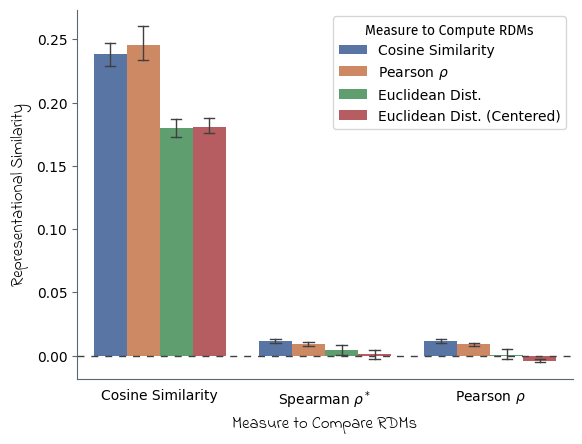

In [19]:
# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    ax = sns.barplot(
        data=methods,
        x="compare",
        y="RSAScore",
        hue="compute",
        palette="deep",
        order=["cosine", "spearman", "correlation"],
        hue_order=["cosine", "correlation", "euclidean", "euclidean_centered"],
        errorbar=("ci", 95),
        capsize=.25,
        err_kws={"color": ".25", "linewidth": 1}
    )
    ax.axhline(
        0,
        color=".25",
        linestyle=(0, (5, 5)),
        linewidth=1
    )

# Add axis labels
ax.set_xlabel("Measure to Compare RDMs", font=indie_flower, size=12)
ax.set_ylabel("Representational Similarity", font=indie_flower, size=12)

# Customize legend
h, _ = ax.get_legend_handles_labels()
ax.legend(
    h,
    ["Cosine Similarity", r"Pearson $\rho$", "Euclidean Dist.", "Euclidean Dist. (Centered)"],
    loc="upper right",
    bbox_to_anchor=(1, 1),
    title="Measure to Compute RDMs",
    title_fontproperties=FontProperties(family="Fira Sans")
)

# Modify tick labels
ax.set_xticks(range(3))
ax.set_xticklabels(["Cosine Similarity", r"Spearman $\rho^*$", r"Pearson $\rho$"])

# Control figure aesthetics
sns.despine(ax=ax)
ax.tick_params(bottom=False, color=anthracite)

fig_methods_similarity = ax.get_figure()
plt.show()

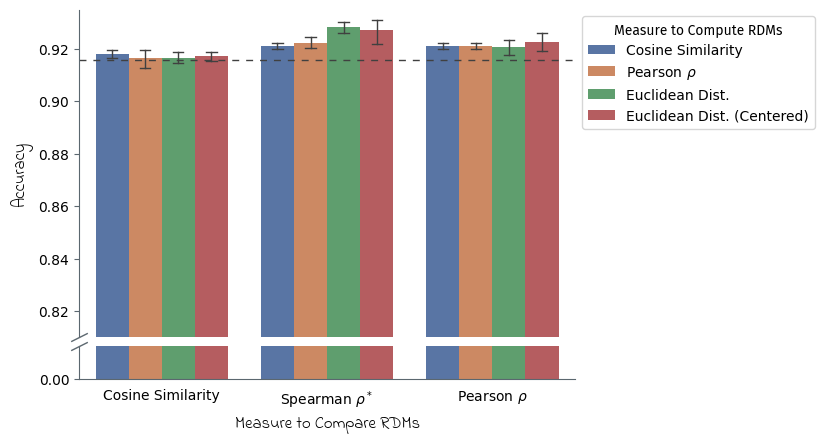

In [20]:
# Prepare plot with "broken" axis
# Adapted from https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
with sns.axes_style({"axes.edgecolor": anthracite}):
    fig_methods_accuracy, (ax_top, ax_bottom) = plt.subplots(
        nrows=2,
        ncols=1,
        sharex=True,
        gridspec_kw={
            "height_ratios": [10, 1],
            "hspace": 0.05
        }
    )
kwargs = dict(
    marker=[(-1, -.5), (1, .5)],
    markersize=12,
    linestyle="none",
    mec=anthracite,
    mew=1,
    clip_on=False
)
ax_top.plot(0, transform=ax_top.transAxes, **kwargs)
ax_bottom.plot(1, transform=ax_bottom.transAxes, **kwargs)
ax_bottom.set_ylim(0, 0.5)

# Plot data
with sns.axes_style({"axes.edgecolor": anthracite}):
    sns.barplot(
        data=methods,
        x="compare",
        y="Acc@1",
        hue="compute",
        palette="deep",
        order=["cosine", "spearman", "correlation"],
        hue_order=["cosine", "correlation", "euclidean", "euclidean_centered"],
        errorbar=("ci", 95),
        capsize=.25,
        err_kws={"color": ".25", "linewidth": 1},
        ax=ax_top
    )
    sns.barplot(
        data=methods,
        x="compare",
        y="Acc@1",
        hue="compute",
        palette="deep",
        order=["cosine", "spearman", "correlation"],
        hue_order=["cosine", "correlation", "euclidean", "euclidean_centered"],
        legend=False,
        ax=ax_bottom
    )
    ax_top.axhline(
        lenet_acc,
        color=".25",
        linestyle=(0, (5, 5)),
        linewidth=1
    )

# Add axis labels
ax_bottom.set_xlabel("Measure to Compare RDMs", font=indie_flower, size=12)
ax_top.set_ylabel("Accuracy", font=indie_flower, size=12)
ax_top.set_xlabel("")
ax_bottom.set_ylabel("")

# Customize legend
h, _ = ax_top.get_legend_handles_labels()
ax_top.legend(
    h,
    ["Cosine Similarity", r"Pearson $\rho$", "Euclidean Dist.", "Euclidean Dist. (Centered)"],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    title="Measure to Compute RDMs",
    title_fontproperties=FontProperties(family="Fira Sans")
)

# Modify tick labels
ax_bottom.set_yticks([0])
ax_bottom.set_yticklabels([f"{0:.2f}"])
ax_bottom.set_xticks(range(3))
ax_bottom.set_xticklabels(["Cosine Similarity", r"Spearman $\rho^*$", r"Pearson $\rho$"])

# Control figure aesthetics
ax_top.set_ylim(0.81, 0.935)
sns.despine(ax=ax_top, bottom=True)
sns.despine(ax=ax_bottom)
ax_top.tick_params(bottom=False, color=anthracite)
ax_bottom.tick_params(bottom=False, color=anthracite)

plt.show()